In [2]:
from os import path
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## Task 1

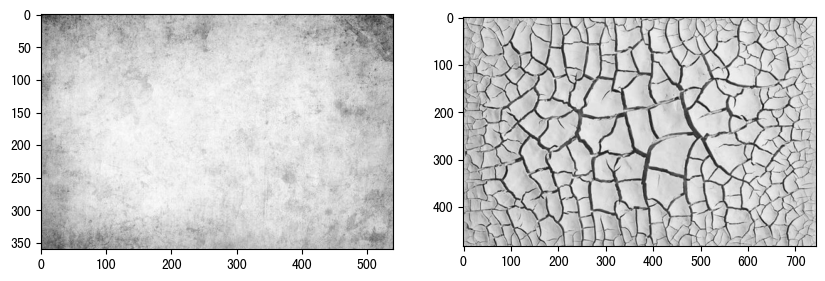

In [3]:
img1 = cv2.imread('images/texture1.jpg', cv2.IMREAD_GRAYSCALE) 
img2 = cv2.imread('images/texture2.jpg', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img2, 'gray')
plt.show()

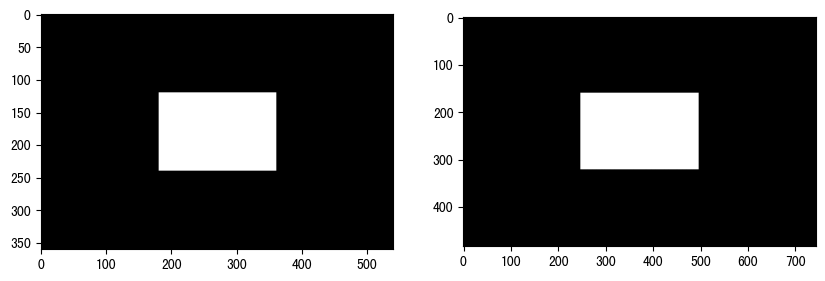

In [4]:
# Create mask
mask1 = np.zeros_like(img1)
h1, w1 = mask1.shape
mask1[h1//3:h1-h1//3, w1//3:w1-w1//3] = 1
mask2 = np.zeros_like(img2)
h2, w2 = mask2.shape
mask2[h2//3:h2-h2//3, w2//3:w2-w2//3] = 1

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mask1, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(mask2, 'gray')
plt.show()

In [5]:
def create_A_matrix(mask):
    # Note: the size of mask is same as dest image
    h, w = mask.shape
    # Map of indices in the mask region
    idx_map = np.full((h, w), -1)
    mask_indices = np.where(mask)
    idx_map[mask_indices] = np.arange(len(mask_indices[0]))
    
    mat = scipy.sparse.lil_matrix((mask.sum(), mask.sum()))
    for y, x in zip(*mask_indices):
        mat_idx = idx_map[y, x]
        # Setting the laplacian operator
        mat[mat_idx, mat_idx] = 4
        neighbors = [(y, x - 1), (y, x + 1), (y - 1, x), (y + 1, x)]
        for ny, nx in neighbors:
            if 0 <= ny < h and 0 <= nx < w and mask[ny, nx]:
                mat[mat_idx, idx_map[ny, nx]] = -1

    return mat.tocsc()

In [6]:
def create_b_vector(dest, mask):
    # Note: the size of mask is same as dest image
    h, w = mask.shape
    # Map of indices in the mask region
    idx_map = np.full((h, w), -1)
    mask_indices = np.where(mask)
    idx_map[mask_indices] = np.arange(len(mask_indices[0]))
    
    # Constructing the b vector
    b = np.zeros(mask.sum())
    for y, x in zip(*mask_indices):
        mat_idx = idx_map[y, x]
        neighbors = [(y, x - 1), (y, x + 1), (y - 1, x), (y + 1, x)]
        for ny, nx in neighbors:
            if 0 <= ny < h and 0 <= nx < w:
                diff = 0
                b[mat_idx] += diff
                if not mask[ny, nx]:
                    b[mat_idx] += dest[ny, nx]
                    
    return b

In [7]:
def blurred_interpolation(dest, mask):
    
    h, w = dest.shape[:2]
    # Map of indices in the mask region
    idx_map = np.full((h, w), -1)
    mask_indices = np.where(mask)
    idx_map[mask_indices] = np.arange(len(mask_indices[0]))

    # Creating matrix A for the masked region
    A = create_A_matrix(mask)

    b = create_b_vector(dest, mask)

    # Solving for unknowns
    f = scipy.sparse.linalg.spsolve(A, b)
    f_normalized = np.clip(f, 0, 255)

    # Cloning the result back into the destination image
    dest_clone = dest.copy()
    for y, x in zip(*mask_indices):
        dest_clone[y, x] = f_normalized[idx_map[y, x]]

    return dest_clone

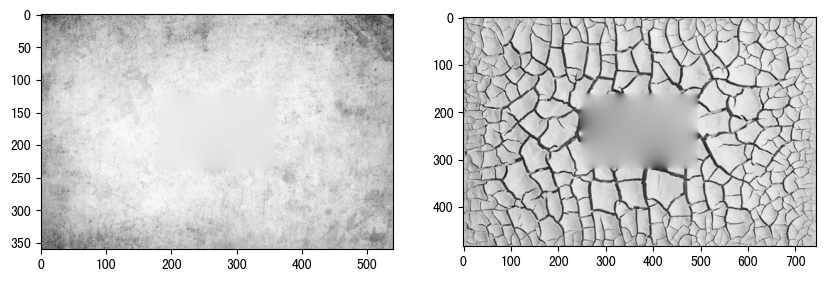

True

In [8]:
result1 = blurred_interpolation(img1, mask1)
result2 = blurred_interpolation(img2, mask2)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(result1, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(result2, 'gray')
plt.show()

cv2.imwrite('results/task1_1.jpg', result1)
cv2.imwrite('results/task1_2.jpg', result2)

<mark>**Comment:**</mark><br>
In this case, as we didn't take gradient information into account, the result will just like a blurred interpolantion, with the region value depends on the edge of the mask area. This usually results in a smooth color transition in the masked area without the texture of the source image. This effect is more noticable in high-frequency texture images.<br>
As the size of the selected region increases, edge pixels will contribute less to the centre region values.

## Task 2

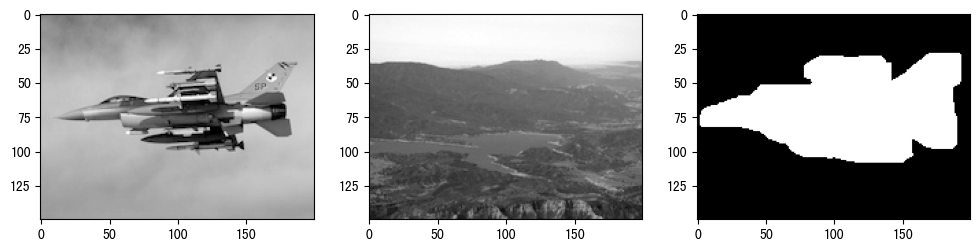

In [9]:
source_gray = cv2.imread('images/source.jpg', cv2.IMREAD_GRAYSCALE)
target_gray = cv2.imread('images/target.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('images/mask.jpg', cv2.IMREAD_GRAYSCALE) 
mask[mask <= 128] = 0
mask[mask > 128] = 1
offset = (0, 0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(source_gray, 'gray') # this is a trick to display the image in here 
plt.subplot(1, 3, 2)
plt.imshow(target_gray, 'gray')
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.show()

In [10]:
# Rewrite create_b_vector function with guidance field introduced
def create_b_vector(src, dest, mask, mode = 'importing'):
    # Note: the size of mask is same as dest image
    h, w = mask.shape
    # Map of indices in the mask region
    idx_map = np.full((h, w), -1)
    mask_indices = np.where(mask)
    idx_map[mask_indices] = np.arange(len(mask_indices[0]))
    
    # Constructing the b vector
    b = np.zeros(mask.sum())
    for y, x in zip(*mask_indices):
        mat_idx = idx_map[y, x]
        neighbors = [(y, x - 1), (y, x + 1), (y - 1, x), (y + 1, x)]
        for ny, nx in neighbors:
            if 0 <= ny < h and 0 <= nx < w:
                if mode == 'importing':
                    diff = src[y, x].astype(np.float32) - src[ny, nx].astype(np.float32)
                if mode == 'mixing':
                    diff1 = dest[y, x].astype(np.float32) - dest[ny, nx].astype(np.float32)
                    diff2 = src[y, x].astype(np.float32) - src[ny, nx].astype(np.float32)
                    diff = diff1 if abs(diff1) > abs(diff2) else diff2
                b[mat_idx] += diff
                if not mask[ny, nx]:
                    b[mat_idx] += dest[ny, nx]
                    
    return b

In [11]:
# seamless cloning in grayscale
def seamless_cloning_gray(src, dest, mask, mode = 'importing'):
    h, w = dest.shape[:2]
    # Map of indices in the mask region
    idx_map = np.full((h, w), -1)
    mask_indices = np.where(mask)
    idx_map[mask_indices] = np.arange(len(mask_indices[0]))
    
    dest_clone = dest.copy()

    # Creating matrix A for the masked region
    A = create_A_matrix(mask)
    
    b = create_b_vector(src, dest, mask, mode)

    # Solving for unknowns
    f = scipy.sparse.linalg.spsolve(A, b)
    f_normalized = np.clip(f, 0, 255)

    # Cloning the result back into the destination image
    for y, x in zip(*mask_indices):
        dest_clone[y, x] = f_normalized[idx_map[y, x]]

    return dest_clone

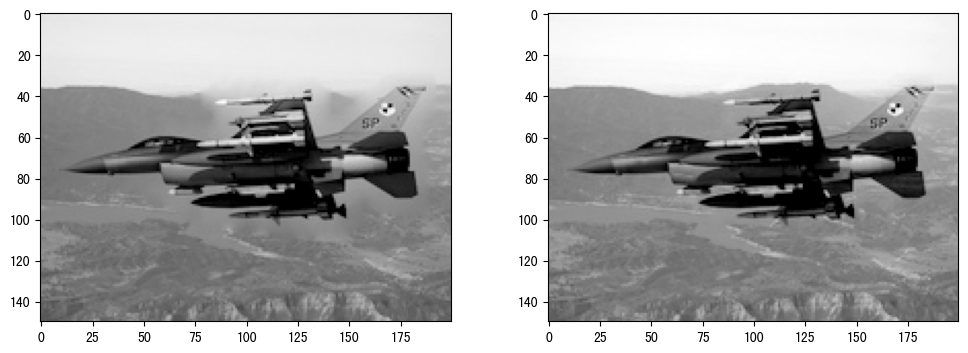

True

In [12]:
result1 = seamless_cloning_gray(source_gray, target_gray, mask, 'importing')
result2 = seamless_cloning_gray(source_gray, target_gray, mask, 'mixing')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(result1, 'gray')
plt.subplot(1, 2, 2)
plt.imshow(result2, 'gray')
plt.show()

cv2.imwrite('results/task2_1.jpg', result1)
cv2.imwrite('results/task2_2.jpg', result2)

## Task 3

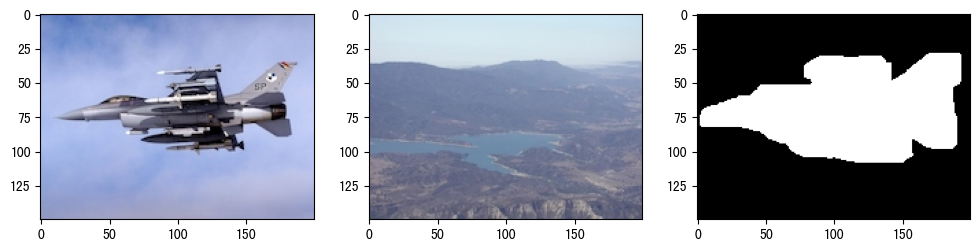

In [13]:
source = cv2.imread('images/source.jpg')
target = cv2.imread('images/target.jpg')
mask = cv2.imread('images/mask.jpg', cv2.IMREAD_GRAYSCALE) 
mask[mask <= 128] = 0
mask[mask > 128] = 1
offset = (0, 0)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(source[:,:,::-1])
plt.subplot(1, 3, 2)
plt.imshow(target[:,:,::-1])
plt.subplot(1, 3, 3)
plt.imshow(mask, cmap='gray')
plt.show()

In [14]:
# seamless cloning in colorspace
def seamless_cloning(src, dest, mask, mode = 'importing'):
    
    h, w = dest.shape[:2]
    # Map of indices in the mask region
    idx_map = np.full((h, w), -1)
    mask_indices = np.where(mask)
    idx_map[mask_indices] = np.arange(len(mask_indices[0]))
    
    dest_clone = dest.copy()

    # Creating matrix A for the masked region
    A = create_A_matrix(mask)
    # Process each channel
    for channel in range(src.shape[2]):
        b = create_b_vector(src[:, :, channel], dest[:, :, channel], mask, mode)

        # Solving for unknowns
        f = scipy.sparse.linalg.spsolve(A, b)
        f_normalized = np.clip(f, 0, 255)

        # Cloning the result back into the destination image
        for y, x in zip(*mask_indices):
            dest_clone[y, x, channel] = f_normalized[idx_map[y, x]]

    return dest_clone

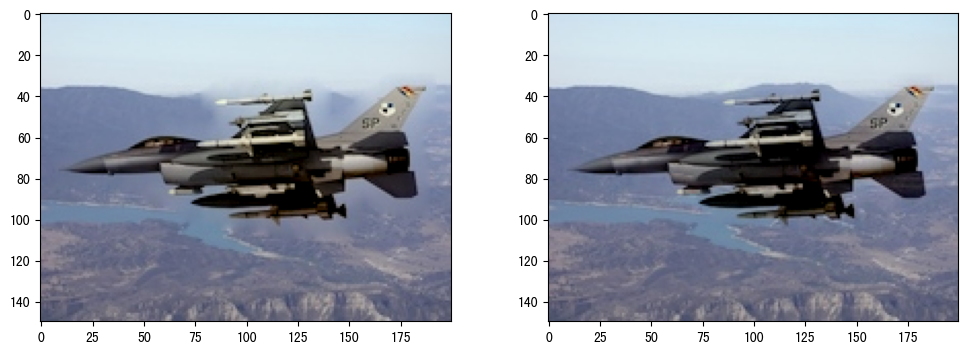

True

In [15]:
result1 = seamless_cloning(source, target, mask, 'importing')
result2 = seamless_cloning(source, target, mask, 'mixing')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(result1[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(result2[:, :, ::-1])
plt.show()

cv2.imwrite('results/task3_1.jpg', result1)
cv2.imwrite('results/task3_2.jpg', result2)

## Task 4

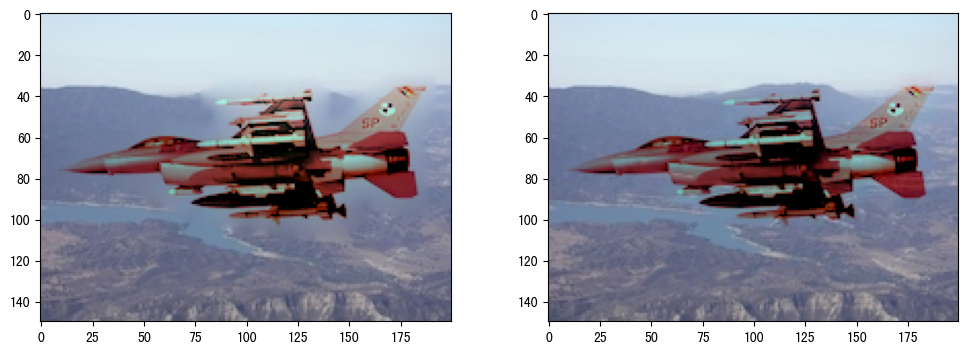

True

In [16]:
# Local Colour Changes
color_factor = [1, 1, 3] # BGR
source_color_changed = source.copy()
source_color_changed = (source_color_changed * color_factor).clip(0, 255).astype(source.dtype)

result1 = seamless_cloning(source_color_changed, target, mask, 'importing')
result2 = seamless_cloning(source_color_changed, target, mask, 'mixing')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(result1[:, :, ::-1])
plt.subplot(1, 2, 2)
plt.imshow(result2[:, :, ::-1])
plt.show()

cv2.imwrite('results/task4_1.jpg', result1)
cv2.imwrite('results/task4_2.jpg', result2)